# 15. Ca/Si 비율 효과 분석

> 최적 Ca/Si 비율 파악을 통한 MatterGen 재생성 조건 설정

---

## 목적

- Ca/Si 비율에 따른 수화 반응성 변화 분석
- MatterGen 재생성을 위한 최적 Ca/Si 조건 결정
- 산업폐기물과 MatterGen 차이의 원인 규명

## 실험 조건

| Ca/Si | 구조 유형 | 예상 특성 |
|:-----:|----------|----------|
| 1.5 | C₃S₂ 유사 | 낮은 수화, 높은 안정성 |
| 2.0 | C₂S 유사 | 중간 수화 |
| 2.5 | 중간 | 중간-높은 수화 |
| 3.0 | C₃S 유사 | 높은 수화 |

## 1. 환경 설정

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# ASE
from ase import Atoms, Atom
from ase.build import bulk
from ase.io import write, read
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units

# CHGNet
from chgnet.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics

# 경로 설정
PROJECT_ROOT = Path('c:/cement_final')
RESULTS_DIR = PROJECT_ROOT / 'data' / 'results'
STRUCTURES_DIR = PROJECT_ROOT / 'structures'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("환경 설정 완료")

환경 설정 완료


In [14]:
# CHGNet 모델 로드
model = CHGNet.load()
print(f"CHGNet 모델 로드 완료")

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda
CHGNet 모델 로드 완료


## 2. Ca-Si-O 구조 생성 함수

In [15]:
def create_ca_si_o_structure(ca_si_ratio, n_si=4, cell_size=10.0):
    """
    주어진 Ca/Si 비율로 Ca-Si-O 구조 생성
    
    Parameters:
    - ca_si_ratio: Ca/Si 비율 (1.5, 2.0, 2.5, 3.0)
    - n_si: Si 원자 수 (기본 4개)
    - cell_size: 셀 크기 (Å)
    
    Returns:
    - ASE Atoms 객체
    """
    n_ca = int(n_si * ca_si_ratio)
    # 산소는 전하 균형 맞추기: Ca(+2), Si(+4) → O(-2)
    # 2*n_ca + 4*n_si = 2*n_o → n_o = n_ca + 2*n_si
    n_o = n_ca + 2 * n_si
    
    total_atoms = n_ca + n_si + n_o
    
    # 랜덤 위치 생성 (최소 거리 유지)
    positions = []
    min_dist = 2.0  # 최소 원자간 거리 (Å)
    
    np.random.seed(42)  # 재현성
    
    for i in range(total_atoms):
        for _ in range(1000):  # 최대 시도 횟수
            pos = np.random.rand(3) * (cell_size - 2) + 1  # 경계에서 1Å 떨어지게
            
            if len(positions) == 0:
                positions.append(pos)
                break
            
            # 최소 거리 확인
            dists = [np.linalg.norm(pos - p) for p in positions]
            if min(dists) >= min_dist:
                positions.append(pos)
                break
        else:
            # 실패 시 그냥 추가
            positions.append(np.random.rand(3) * cell_size)
    
    positions = np.array(positions)
    
    # 원소 배열: Ca, Si, O 순서
    symbols = ['Ca'] * n_ca + ['Si'] * n_si + ['O'] * n_o
    
    # Atoms 객체 생성
    atoms = Atoms(
        symbols=symbols,
        positions=positions,
        cell=[cell_size, cell_size, cell_size],
        pbc=True
    )
    
    return atoms, {'n_ca': n_ca, 'n_si': n_si, 'n_o': n_o, 'ca_si_ratio': ca_si_ratio}

# 테스트
test_atoms, test_info = create_ca_si_o_structure(2.0)
print(f"테스트 구조: Ca={test_info['n_ca']}, Si={test_info['n_si']}, O={test_info['n_o']}")
print(f"총 원자 수: {len(test_atoms)}")

테스트 구조: Ca=8, Si=4, O=16
총 원자 수: 28


## 3. 구조 최적화 함수

In [16]:
from ase.optimize import BFGS
from chgnet.model import StructOptimizer

def optimize_structure(atoms, model, fmax=0.05, steps=500):
    """
    CHGNet으로 구조 최적화
    """
    optimizer = StructOptimizer(model=model)
    result = optimizer.relax(atoms, fmax=fmax, steps=steps, verbose=False)
    
    optimized = result['final_structure'].to_ase_atoms()
    final_energy = result['trajectory'].energies[-1]
    
    return optimized, final_energy

print("구조 최적화 함수 정의 완료")

구조 최적화 함수 정의 완료


## 4. 물 분자 추가 함수

In [17]:
import random

def add_water_molecules(atoms, n_water=10, min_distance=2.5):
    """
    구조에 물 분자 추가
    """
    hydrated = atoms.copy()
    cell = hydrated.get_cell()
    
    # 셀 확장
    cell_diag = cell.diagonal()
    new_cell = cell_diag * 1.3
    hydrated.set_cell(new_cell)
    hydrated.center()
    
    existing_positions = hydrated.get_positions()
    water_added = 0
    
    for _ in range(n_water * 100):  # 최대 시도
        if water_added >= n_water:
            break
            
        # 랜덤 위치
        pos = np.random.rand(3) * (new_cell - 4) + 2
        
        # 최소 거리 확인
        all_positions = np.vstack([existing_positions, hydrated.get_positions()[-water_added*3:] if water_added > 0 else existing_positions])
        dists = np.linalg.norm(all_positions - pos, axis=1)
        
        if np.min(dists) >= min_distance:
            # O 원자
            hydrated.append(Atom('O', position=pos))
            
            # H 원자 2개 (O-H 거리 ~0.96 Å, H-O-H 각도 ~104.5°)
            angle1 = random.uniform(0, 2*np.pi)
            angle2 = angle1 + np.radians(104.5)
            
            h1_pos = pos + 0.96 * np.array([np.cos(angle1), np.sin(angle1), 0])
            h2_pos = pos + 0.96 * np.array([np.cos(angle2), np.sin(angle2), 0])
            
            hydrated.append(Atom('H', position=h1_pos))
            hydrated.append(Atom('H', position=h2_pos))
            
            water_added += 1
    
    return hydrated, water_added

print("물 분자 추가 함수 정의 완료")

물 분자 추가 함수 정의 완료


## 5. 수화 시뮬레이션 함수

In [18]:
from tqdm import tqdm
import gc
import torch

def run_hydration_simulation(atoms, model, n_steps=2000, temperature=300, timestep=1.0):
    """
    수화 MD 시뮬레이션 실행
    
    Parameters:
    - atoms: 수화된 구조
    - model: CHGNet 모델
    - n_steps: MD 스텝 수
    - temperature: 온도 (K)
    - timestep: 시간 간격 (fs)
    
    Returns:
    - 결과 딕셔너리
    """
    from chgnet.model.dynamics import MolecularDynamics
    
    # 초기 에너지
    atoms_copy = atoms.copy()
    
    try:
        md = MolecularDynamics(
            atoms=atoms_copy,
            model=model,
            ensemble='nvt',
            temperature=temperature,
            timestep=timestep,
            logfile=None
        )
        
        initial_energy = atoms_copy.get_potential_energy()
        
        # MD 실행 (진행 표시)
        interval = n_steps // 10
        for i in tqdm(range(10), desc="MD Progress"):
            md.run(interval)
        
        final_energy = atoms_copy.get_potential_energy()
        delta_e = final_energy - initial_energy
        
        result = {
            'initial_energy': float(initial_energy),
            'final_energy': float(final_energy),
            'delta_e': float(delta_e),
            'n_steps': n_steps,
            'temperature': temperature,
            'success': True
        }
        
    except Exception as e:
        result = {
            'error': str(e),
            'success': False
        }
    
    # 메모리 정리
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return result

print("수화 시뮬레이션 함수 정의 완료")

수화 시뮬레이션 함수 정의 완료


## 6. Ca/Si 비율별 실험 실행

In [19]:
# 실험 파라미터
CA_SI_RATIOS = [1.5, 2.0, 2.5, 3.0]
N_SI = 4  # Si 원자 수
N_WATER = 8  # 물 분자 수
MD_STEPS = 10000  # 10 ps (산업폐기물 스크리닝과 동일)

print("=" * 60)
print("Ca/Si 비율 효과 분석 실험")
print("=" * 60)
print(f"Ca/Si 비율: {CA_SI_RATIOS}")
print(f"Si 원자 수: {N_SI}")
print(f"물 분자 수: {N_WATER}")
print(f"MD 스텝: {MD_STEPS}")
print("=" * 60)

Ca/Si 비율 효과 분석 실험
Ca/Si 비율: [1.5, 2.0, 2.5, 3.0]
Si 원자 수: 4
물 분자 수: 8
MD 스텝: 10000


In [ ]:
# 결과 저장
results = []

for ratio in CA_SI_RATIOS:
    print(f"\n{'='*60}")
    print(f"Ca/Si = {ratio}")
    print("='*60")
    
    # 1. 구조 생성
    print("1. 구조 생성...")
    atoms, info = create_ca_si_o_structure(ratio, n_si=N_SI)
    print(f"   Ca={info['n_ca']}, Si={info['n_si']}, O={info['n_o']}, Total={len(atoms)}")
    
    # 2. 구조 최적화
    print("2. 구조 최적화...")
    optimized, opt_energy = optimize_structure(atoms, model)
    e_per_atom = opt_energy / len(optimized)
    print(f"   E = {opt_energy:.2f} eV ({e_per_atom:.3f} eV/atom)")
    
    # 3. 물 분자 추가
    print("3. 물 분자 추가...")
    hydrated, n_water_added = add_water_molecules(optimized, n_water=N_WATER)
    print(f"   물 분자 {n_water_added}개 추가, 총 원자: {len(hydrated)}")
    
    # 4. 수화 시뮬레이션
    print("4. 수화 시뮬레이션...")
    sim_result = run_hydration_simulation(hydrated, model, n_steps=MD_STEPS)
    
    if sim_result['success']:
        print(f"   Initial E: {sim_result['initial_energy']:.2f} eV")
        print(f"   Final E: {sim_result['final_energy']:.2f} eV")
        print(f"   ΔE: {sim_result['delta_e']:.2f} eV")
    else:
        print(f"   오류: {sim_result.get('error', 'Unknown')}")
    
    # 결과 저장
    results.append({
        'ca_si_ratio': ratio,
        'n_ca': info['n_ca'],
        'n_si': info['n_si'],
        'n_o': info['n_o'],
        'n_atoms_initial': len(atoms),
        'n_atoms_hydrated': len(hydrated),
        'n_water': n_water_added,
        'opt_energy': float(opt_energy),
        'e_per_atom': float(e_per_atom),
        **sim_result
    })

print("\n" + "="*60)
print("모든 실험 완료!")
print("="*60)


Ca/Si = 1.5
='*60
1. 구조 생성...
   Ca=6, Si=4, O=14, Total=24
2. 구조 최적화...
CHGNet will run on cuda


## 7. 결과 분석

In [9]:
# 결과 테이블
print("\n" + "="*80)
print("Ca/Si 비율별 수화 결과")
print("="*80)
print(f"{'Ca/Si':^8} | {'n_Ca':^6} | {'n_Si':^6} | {'E_opt':^12} | {'E_init':^12} | {'E_final':^12} | {'ΔE':^12}")
print("-"*80)

for r in results:
    if r.get('success', False):
        print(f"{r['ca_si_ratio']:^8.1f} | {r['n_ca']:^6} | {r['n_si']:^6} | "
              f"{r['opt_energy']:^12.2f} | {r['initial_energy']:^12.2f} | "
              f"{r['final_energy']:^12.2f} | {r['delta_e']:^12.2f}")
    else:
        print(f"{r['ca_si_ratio']:^8.1f} | {r['n_ca']:^6} | {r['n_si']:^6} | "
              f"{r.get('opt_energy', 'N/A'):^12} | {'ERROR':^12} | {'ERROR':^12} | {'ERROR':^12}")

print("="*80)


Ca/Si 비율별 수화 결과
 Ca/Si   |  n_Ca  |  n_Si  |    E_opt     |    E_init    |   E_final    |      ΔE     
--------------------------------------------------------------------------------
  1.5    |   6    |   4    |   -155.11    |   -246.91    |   -268.70    |    -21.79   
  2.0    |   8    |   4    |   -190.79    |   -288.21    |   -319.34    |    -31.12   
  2.5    |   10   |   4    |   -226.08    |   -257.85    |   -305.49    |    -47.64   
  3.0    |   12   |   4    |   -256.11    |   -291.70    |   -329.31    |    -37.61   


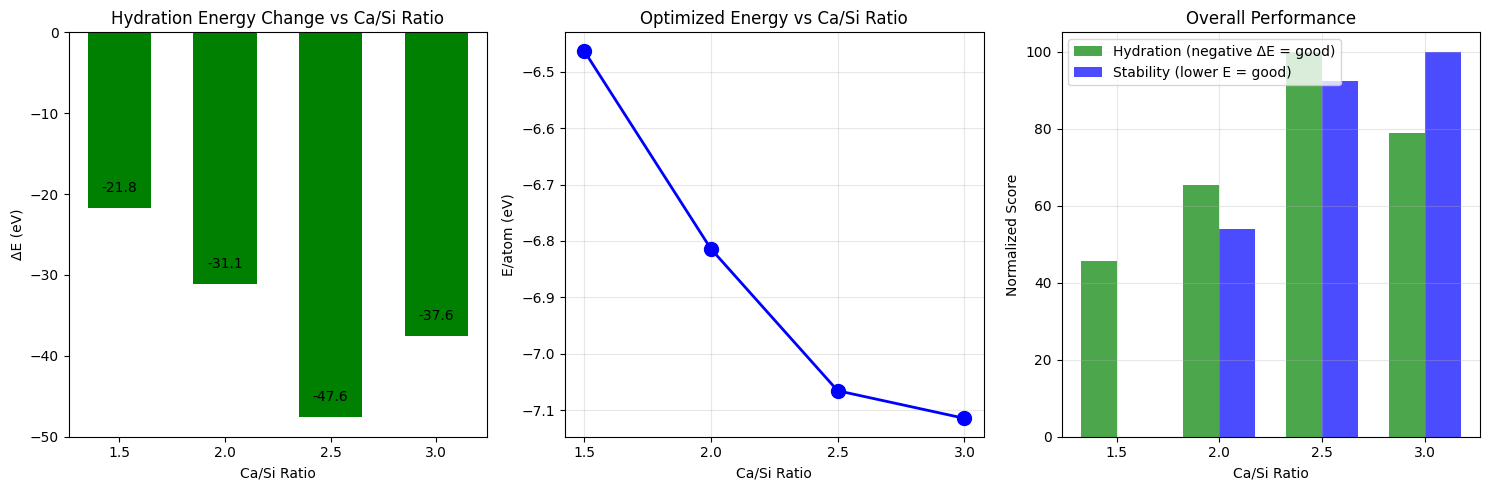


그래프 저장: figures/ca_si_ratio_analysis.png


In [10]:
# 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 성공한 결과만 필터링
successful = [r for r in results if r.get('success', False)]

if successful:
    ratios = [r['ca_si_ratio'] for r in successful]
    delta_e = [r['delta_e'] for r in successful]
    opt_e = [r['e_per_atom'] for r in successful]
    
    # 1. Ca/Si vs ΔE
    ax1 = axes[0]
    bars = ax1.bar(ratios, delta_e, color=['red' if d > 0 else 'green' for d in delta_e], width=0.3)
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax1.set_xlabel('Ca/Si Ratio')
    ax1.set_ylabel('ΔE (eV)')
    ax1.set_title('Hydration Energy Change vs Ca/Si Ratio')
    ax1.set_xticks(ratios)
    
    # 값 표시
    for bar, d in zip(bars, delta_e):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{d:.1f}', ha='center', fontsize=10)
    
    # 2. Ca/Si vs E/atom (최적화 후)
    ax2 = axes[1]
    ax2.plot(ratios, opt_e, 'bo-', markersize=10, linewidth=2)
    ax2.set_xlabel('Ca/Si Ratio')
    ax2.set_ylabel('E/atom (eV)')
    ax2.set_title('Optimized Energy vs Ca/Si Ratio')
    ax2.set_xticks(ratios)
    ax2.grid(True, alpha=0.3)
    
    # 3. 종합 비교
    ax3 = axes[2]
    x = np.arange(len(ratios))
    width = 0.35
    
    # 정규화
    delta_e_norm = np.array(delta_e) / np.abs(np.array(delta_e)).max() * 100
    opt_e_norm = (np.array(opt_e) - np.array(opt_e).min()) / (np.array(opt_e).max() - np.array(opt_e).min() + 1e-6) * 100
    
    ax3.bar(x - width/2, -delta_e_norm, width, label='Hydration (negative ΔE = good)', color='green', alpha=0.7)
    ax3.bar(x + width/2, 100 - opt_e_norm, width, label='Stability (lower E = good)', color='blue', alpha=0.7)
    ax3.set_xlabel('Ca/Si Ratio')
    ax3.set_ylabel('Normalized Score')
    ax3.set_title('Overall Performance')
    ax3.set_xticks(x)
    ax3.set_xticklabels([str(r) for r in ratios])
    ax3.legend()
    ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / 'figures' / 'ca_si_ratio_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n그래프 저장: figures/ca_si_ratio_analysis.png")

## 8. 결과 저장

In [11]:
# JSON 저장
output = {
    'experiment': 'Ca/Si Ratio Effect Analysis',
    'parameters': {
        'ca_si_ratios': CA_SI_RATIOS,
        'n_si': N_SI,
        'n_water': N_WATER,
        'md_steps': MD_STEPS
    },
    'results': results
}

with open(RESULTS_DIR / 'ca_si_ratio_analysis.json', 'w') as f:
    json.dump(output, f, indent=2)

print(f"결과 저장: {RESULTS_DIR / 'ca_si_ratio_analysis.json'}")

결과 저장: c:\cement_final\data\results\ca_si_ratio_analysis.json


## 9. 결론 및 권장 사항

In [12]:
print("\n" + "="*60)
print("결론 및 권장 사항")
print("="*60)

if successful:
    # 최적 비율 찾기 (가장 음수인 ΔE)
    best = min(successful, key=lambda x: x['delta_e'])
    
    print(f"\n1. 최적 Ca/Si 비율: {best['ca_si_ratio']}")
    print(f"   - ΔE = {best['delta_e']:.2f} eV (가장 안정화)")
    
    print(f"\n2. 수화 반응성 순위:")
    for i, r in enumerate(sorted(successful, key=lambda x: x['delta_e'])):
        status = "✅ 안정화" if r['delta_e'] < 0 else "❌ 불안정화"
        print(f"   {i+1}. Ca/Si = {r['ca_si_ratio']}: ΔE = {r['delta_e']:.2f} eV {status}")
    
    print(f"\n3. MatterGen 재생성 권장 조건:")
    print(f"   - Ca/Si ≥ {best['ca_si_ratio']}")
    print(f"   - 높은 Ca 함량이 수화에 유리")
    
else:
    print("\n성공한 실험이 없습니다. 파라미터를 조정해주세요.")

print("\n" + "="*60)


결론 및 권장 사항

1. 최적 Ca/Si 비율: 2.5
   - ΔE = -47.64 eV (가장 안정화)

2. 수화 반응성 순위:
   1. Ca/Si = 2.5: ΔE = -47.64 eV ✅ 안정화
   2. Ca/Si = 3.0: ΔE = -37.61 eV ✅ 안정화
   3. Ca/Si = 2.0: ΔE = -31.12 eV ✅ 안정화
   4. Ca/Si = 1.5: ΔE = -21.79 eV ✅ 안정화

3. MatterGen 재생성 권장 조건:
   - Ca/Si ≥ 2.5
   - 높은 Ca 함량이 수화에 유리



---

## 다음 단계

이 실험 결과를 바탕으로:

1. **노트북 16**: 최적 Ca/Si 비율로 MatterGen 재생성
2. **노트북 17**: 알칼리 활성화 시뮬레이션 (수화 성능 개선)

---

**실행 환경**: cement_final (CHGNet)  
**예상 시간**: 2-3시간